###Import python modules

In [1]:
import nag4py.g13 as g13
import pandas as pd
import numpy as np
import nag4py.util as util
import matplotlib.pyplot as plt
import nag4py.e01 as e01
import pymongo
%matplotlib inline  

###Set name of stock

In [2]:
stock_name = 'volkswagen'

#Create Mongodb (This would already exist in a normal setup)

###Read in csv file downloaded from Yahoo historic stock prices filename:stock_name.csv

In [3]:
data = pd.read_csv('{}.csv'.format(stock_name))

###Convert date to datetime datatype and set as index

In [4]:
data['Date'] = pd.to_datetime(data['Date'], format="%d/%m/%Y")
data = data.set_index('Date')

###Open a connection to the mongo client. The client (mongod) must be running.

In [5]:
client = pymongo.MongoClient()

###Select the Database

In [6]:
db = client.stock

###Load the specific collection

In [7]:
collection = db['{}'.format(stock_name)]

###Populate the collection (First we drop the collection so that it is empty)

In [8]:
collection.drop()
for date in data.index.values:
    post = {"Date":"{}".format(date),
           "Close":float("{}".format(data.ix[date]['Close'])),
           "Adj Close":float("{}".format(data.ix[date]['Adj Close'])),
           "High":float("{}".format(data.ix[date]['High'])),
           "Low":float("{}".format(data.ix[date]['Low'])),
           "Open":float("{}".format(data.ix[date]['Open'])),
           "Volume":float("{}".format(data.ix[date]['Volume']))}
    collection.insert_one(post).inserted_id

#Reading Mongodb data

###Put Collection into DataFrame and set the 'Date' as the index

In [9]:
data = pd.DataFrame(list(collection.find())).set_index('Date')

###Change some datatypes

In [10]:
data['_id'] = data['_id'].astype(str)

In [11]:
data = data.set_index(data.index.astype('datetime64'))

###Rename column

In [12]:
data = data.rename(columns = {'_id': 'ID'})

#Calculate Change Points

The PELT algorithm assumes that the data is univariate (evenly spaced).

The stock prices have gaps for holidays and other reasons.

Therefore, the gaps must be filled, by interpolated data, before performing the change point analysis.

In [13]:
known_dates = data.index.order()

####Select the price to do the change point analysis on, i.e. High, Close, Low, Open

In [14]:
price_type = 'High'
known_prices = getattr(data, price_type).sort_index().values

###Determine all the dates between the first and last piece of data

In [15]:
all_dates = pd.date_range(known_dates[0], known_dates[-1])

###Reindex the data with all the dates

In [16]:
all_data = data.reindex(all_dates)

###Determine the missing dates

In [17]:
missing_dates = all_dates.difference(known_dates)

###Define a wrapper function for the NAG monotonicity preserving interpolating routine

In [18]:
def mono_inter(x, y, missing_dates):
    """This function calcuates the missing prices from the known dates, known prices and missing dates. 
        x is the known dates
        y is the known prices
        md is the missing dates"""
    d = np.zeros(len(x))
    fail = util.noisy_fail()
    e01.nag_monotonic_interpolant(len(x), x, y, d, fail)
    missing_prices = np.zeros(len(missing_dates))
    fail = util.noisy_fail()
    e01.nag_monotonic_evaluate(len(x), x, y, d, len(missing_dates), missing_dates, missing_prices, fail)
    if fail.iflag != 0:
        print fail.message
    return missing_prices

###Calculate the missing prices

In [19]:
missing_prices = mono_inter(known_dates.values.astype(float), known_prices, missing_dates.values.astype(float))

###Merge the missing prices and the known data

In [20]:
missing_prices_list = missing_prices.tolist()
for row in all_data.iterrows():
    if pd.isnull(row[1][price_type]):
        all_data.loc[row[0], price_type] = missing_prices_list.pop(0)

###Plot the complete dataset

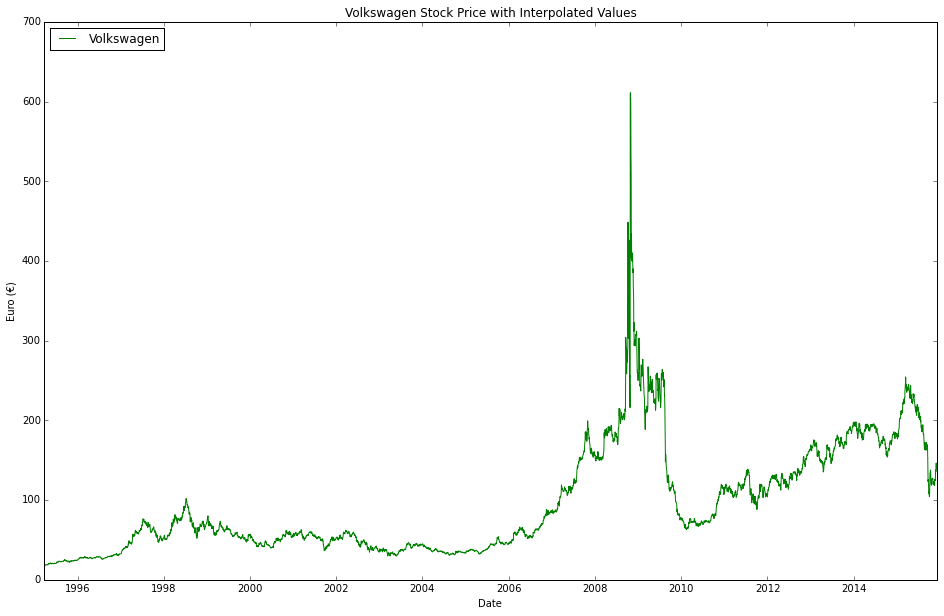

In [21]:
fig = plt.figure()
fig.set_size_inches(16, 10)
plt.plot(all_data.index, all_data[price_type], 'g', label = 'Volkswagen')
plt.title('Volkswagen Stock Price with Interpolated Values')
plt.legend(loc = 2)
plt.ylabel('Euro '+u"(\u20AC)")
plt.xlabel('Date')
plt.show()

##Comparison between known data an interpolated data

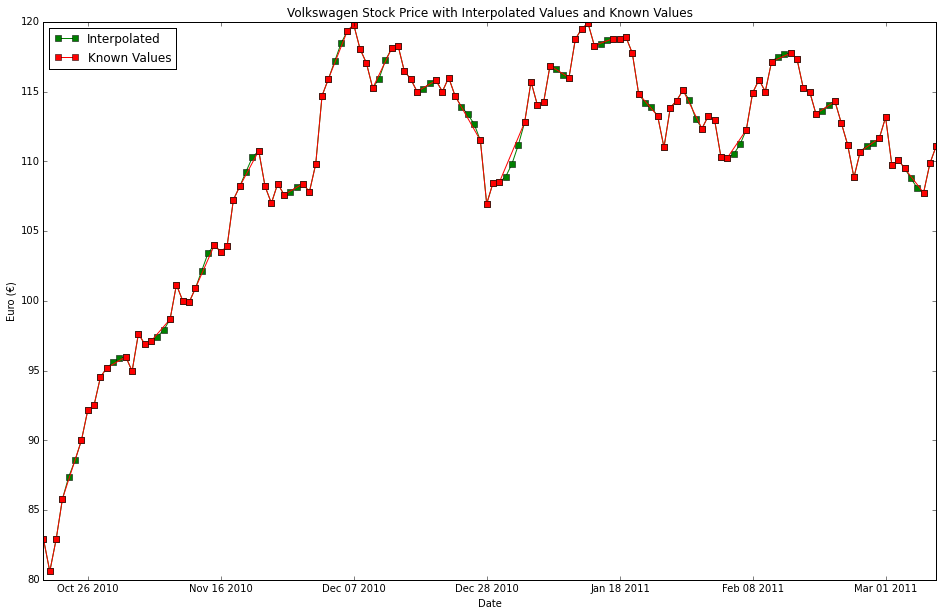

In [22]:
start = 4000
end = 4100
s = np.where(all_dates==known_dates[start])[0][0]
e = np.where(all_dates==known_dates[end])[0][0]
fig = plt.figure()
fig.set_size_inches(16, 10)
plt.plot(all_data.index[s:e], all_data[price_type][s:e], 'gs-', label = 'Interpolated')
plt.plot(known_dates[start:end], known_prices[start:end], 'rs-', label = 'Known Values')
plt.title('Volkswagen Stock Price with Interpolated Values and Known Values')
plt.legend(loc = 2)
plt.ylabel('Euro '+u"(\u20AC)")
plt.xlabel('Date')
plt.show()

#Apply the PELT algorithm to the complete data set

###Define some parameters

In [23]:
dist = util.Nag_TS_ChangeType()
dist_change_point_type_dict = {'Nag_NormalMean': util.Nag_NormalMean, 
                              'Nag_NormalStd': util.Nag_NormalStd, 
                              'Nag_NormalMeanStd': util.Nag_NormalMeanStd, 
                              'Nag_GammaScale': util.Nag_GammaScale, 
                              'Nag_ExponentialLambda': util.Nag_ExponentialLambda, 
                              'Nag_PoissonLambda': util.Nag_PoissonLambda}
dist_change_point_type = 'Nag_NormalMean'
dist = dist_change_point_type_dict[dist_change_point_type]

###Define the penalty term based on the documentation

In [24]:
def penalty_term(dist_change_point_type, time_series_len, penalty_method = 'SIC'):
    if dist_change_point_type == 'Nag_NormalMeanStd':
        p = 2
    else:
        p = 1
    penalty_method_dict = {'SIC': p * np.log(time_series_len), 
                           'BIC': p * np.log(time_series_len), 
                           'AIC': p * 2, 
                           'Hannan-Quinn': 2 * p * np.log(np.log(time_series_len))}
    return penalty_method_dict[penalty_method]

### Calculate the Standard Deviation and the Mean using nag_tsa_mean_range

In [25]:
n = len(all_data[price_type])
m = n
std = np.zeros(n/m, dtype=np.float64)
mean = np.zeros(n/m, dtype=np.float64)
fail = util.noisy_fail()
g13.nag_tsa_mean_range(len(all_data[price_type]), np.array(all_data[price_type].values), m, util.Nag_UseSD, std, mean, fail)
if fail.iflag != 0:
    print fail.message

###Calculate the changepoints

In [26]:
beta = penalty_term(dist_change_point_type, n, 'SIC')
print 'Pentalty Term', beta
minss = 2
param = np.ndarray(1)
if dist_change_point_type == 'Nag_NormalMean':
    param[0] = std[0]
elif dist_change_point_type == 'Nag_NormalMeanStd':
    param[0] = mean[0]
else:
    param[0] = 0
ntau = np.zeros(n, dtype=int)
tau = np.zeros(n, dtype=int)
sparam = np.zeros(2*n+2)
fail = util.noisy_fail()
g13.nag_tsa_cp_pelt(dist, n, np.array(all_data[price_type].values), beta, minss, param, ntau, tau, sparam, fail)
if fail.iflag != 0:
    print fail.message

Pentalty Term 8.93115542978


###Store the mean value between the changepoints

In [27]:
m = ntau[0]
change_points = [0] + tau[0:m-1].tolist()
mean = []
std = []
for i in range(0, m):
    mean.append(sparam[2*(i+1)-2])
    std.append(sparam[2*(i+1)-1])
#This is to plot the final mean bar
change_points.append(len(all_data[price_type].values)-1)
std.append(std[-1])
mean.append(mean[-1])

###Plot the Changepoints and the mean value between

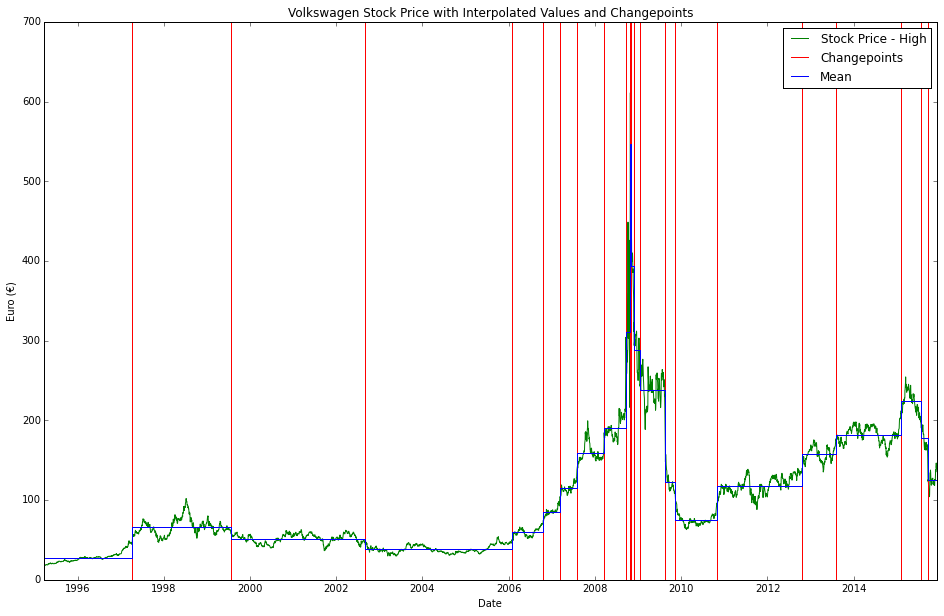

In [28]:
fig = plt.figure()
fig.set_size_inches(16, 10)
plt.plot(all_dates, all_data[price_type].values, 'g', label = 'Stock Price - {}'.format(price_type))
for change_point in change_points:
    plt.axvline(all_dates[change_point], color = 'r')
plt.axvline(all_dates[change_point], color = 'r', label = 'Changepoints')
plt.step(all_dates[change_points], mean, where='post', label = 'Mean')
plt.title('Volkswagen Stock Price with Interpolated Values and Changepoints')
plt.legend()
plt.ylabel('Euro '+u"(\u20AC)")
plt.xlabel('Date')
plt.show()

##A plot showing the changepoint that occurred at the time of the recent emissions scandal

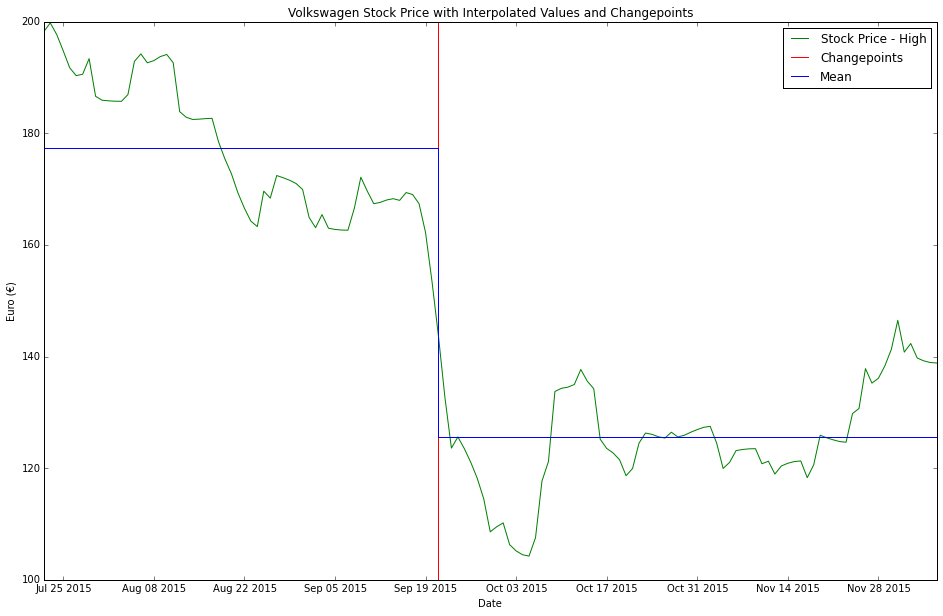

In [29]:
fig = plt.figure()
fig.set_size_inches(16, 10)
plt.plot(all_dates[change_points[-3]:], all_data[price_type].values[change_points[-3]:], 'g', label = 'Stock Price - {}'.format(price_type))
for change_point in change_points[-3:]:
    plt.axvline(all_dates[change_point], color = 'r')
plt.axvline(all_dates[change_point], color = 'r', label = 'Changepoints')
plt.step(all_dates[change_points][-3:], mean[-3:], where='post', label='Mean')
plt.title('Volkswagen Stock Price with Interpolated Values and Changepoints')
plt.legend()
plt.ylabel('Euro '+u"(\u20AC)")
plt.xlabel('Date')
plt.show()

In [30]:
print("The change point occurs on the {}.".format(all_dates[change_points][-3:][1]))

The change point occurs on the 2015-09-21 00:00:00.
